# Peter O'Mahony
# ID: 8361967
# E-tivity 3 - Regression

_Open a new Jupyter notebook and name it etivity3_regression.ipynb. In this notebook, train three regression pipelines with Random Forest, Linear Regression and a third regressor of your choice as the final estimator, respectively, for predicting the value of `insurance_cost`._

_Requirements:_

* _For each regressor, include data preparation and dimensionality reduction steps in the main pipeline._
* _You can choose any regressor as the third one. Some options are SVR and MLPRegressor, but you are not limited to them._
* _For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique._
* _Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-2 - Regression and Dimensionality Reduction.ipynb to evaluate and compare the models you have trained and pick the best one._
* _Summarise your experience in a markdown cell (max 150 words in a markdown cell)._


In [55]:
import pandas as pd # type: ignore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config, svm
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing   import OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer #needed for data preparation
from sklearn.svm import SVR

%matplotlib inline

# set display settings so that we use full width of my screen
pd.options.display.max_rows = 50
pd.options.display.max_columns = None
pd.options.display.width = 2000
pd.options.display.float_format = "{:,.2f}".format


In [56]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender   bmi  children smoker     region  insurance_cost
0   18    male 33.77         1     no  southeast        1,725.55
1   18    male 34.10         0     no  southeast        1,137.01
2   18  female 26.32         0     no  northeast        2,198.19
3   18  female 38.66         2     no  northeast        3,393.36
4   18  female 35.62         0     no  northeast        2,211.13

In [57]:
# This is probably not useful but it is interesting
df['cost_per_person'] = df.insurance_cost/(df.children+1)

Total rows with outliers:       230.0
Total rows with missing values: 0.0
Description
              age      bmi  children  insurance_cost  cost_per_person  gender  smoker  region
count   1,338.00 1,338.00  1,338.00        1,338.00         1,338.00     NaN     NaN     NaN
mean       39.21    30.66      1.09       13,270.42         8,269.59     NaN     NaN     NaN
std        14.05     6.10      1.21       12,110.01         9,398.90     NaN     NaN     NaN
min        18.00    15.96      0.00        1,121.87           768.00     NaN     NaN     NaN
25%        27.00    26.30      0.00        4,740.29         2,206.17     NaN     NaN     NaN
50%        39.00    30.40      1.00        9,382.03         4,317.09     NaN     NaN     NaN
75%        51.00    34.69      2.00       16,639.91        11,454.97     NaN     NaN     NaN
max        64.00    53.13      5.00       63,770.43        63,770.43     NaN     NaN     NaN
IQR        24.00     8.40      2.00       11,899.63         9,248.80     NaN

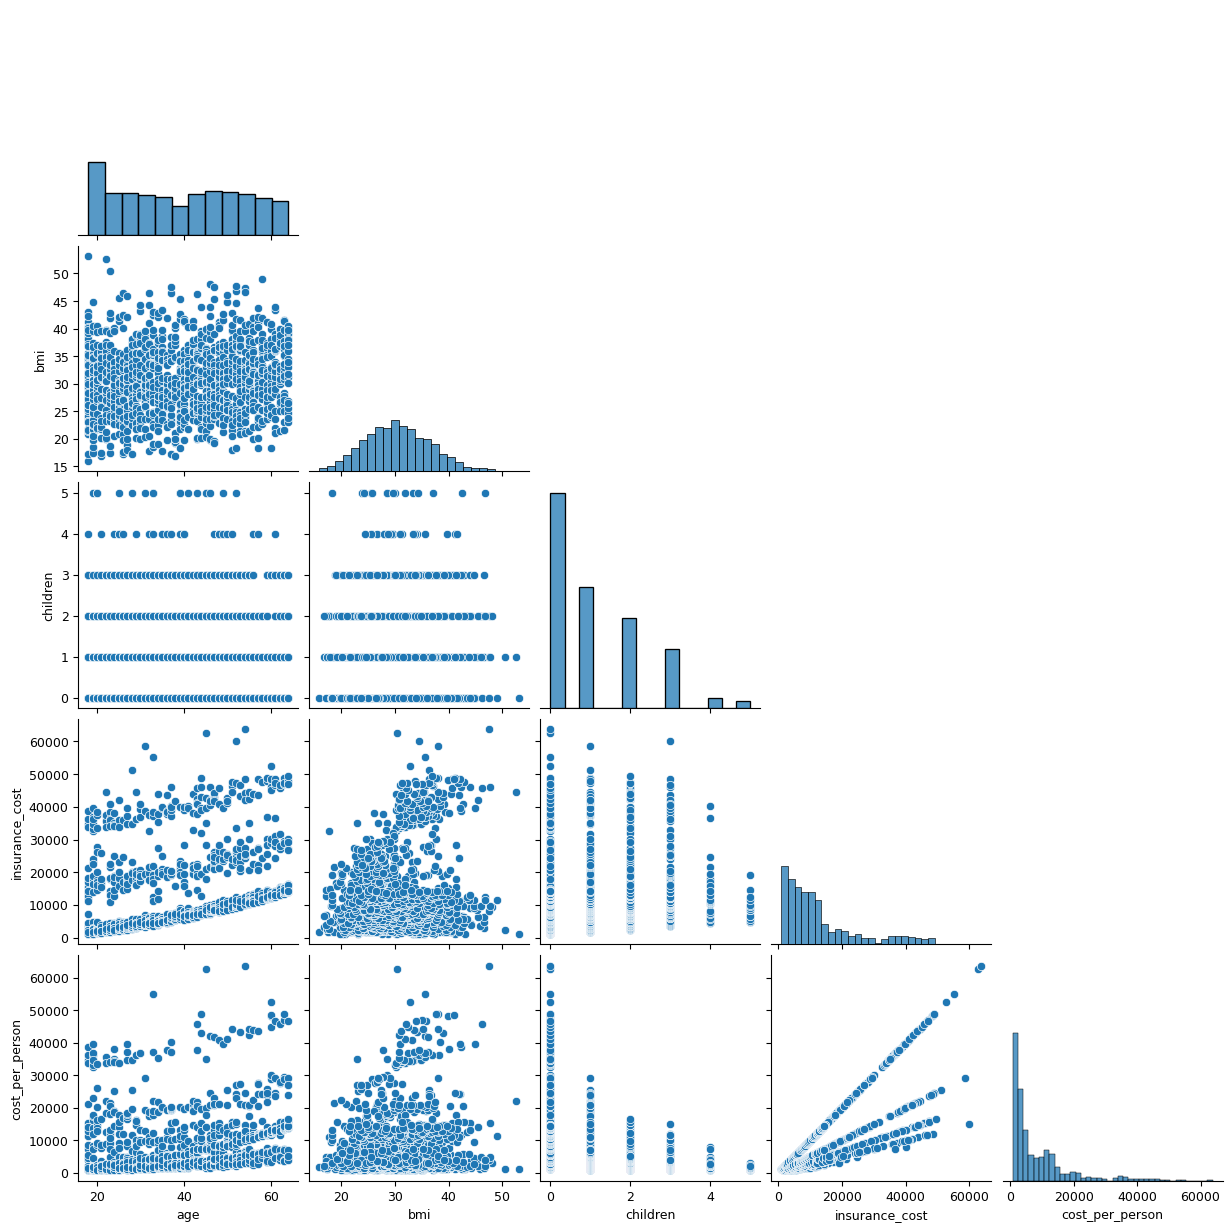

In [58]:
# create a list of analytics for each numeric feature
desc = df.describe()

for num_feature in desc:
    # calculate the inter quartile range
    desc.loc['IQR',   num_feature] = desc[num_feature]['75%'] - desc[num_feature]['25%']
    desc.loc['out_lo',num_feature] = desc[num_feature]['25%'] - desc[num_feature]['IQR'] * 1.5
    desc.loc['out_hi',num_feature] = desc[num_feature]['75%'] + desc[num_feature]['IQR'] * 1.5

    # identify the high and low boundaries for outliers
    out_lo = desc[num_feature]['25%'] - desc[num_feature]['IQR'] * 1.5
    out_hi = desc[num_feature]['75%'] + desc[num_feature]['IQR'] * 1.5

    # count the number of outliers
    out_cnt =( (df[num_feature] > out_hi) | (df[num_feature] < out_lo)).sum()
    desc.loc['out_cnt',num_feature] = out_cnt

    # count the number of missing values
    desc.loc['missing',num_feature] = df[num_feature].isna().sum()


# for all the categorical features, count the number of missing values
objects = df.select_dtypes(include=['object']).columns.tolist()
for num_feature in objects:
    desc.loc['missing',num_feature] = df[num_feature].isna().sum()

# show how many rows contained outliers
print(f'Total rows with outliers:      ',desc.loc['out_cnt'].sum())
print(f'Total rows with missing values:',desc.loc['missing'].sum())

# show the analytics
print('Description\n',desc)

# show only the useful plots (and omit duplicate transpositional plots)
sns.pairplot(df, corner=True)

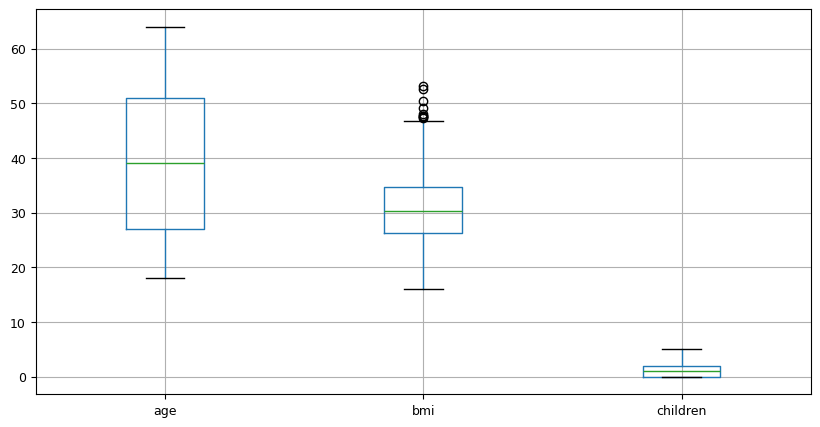

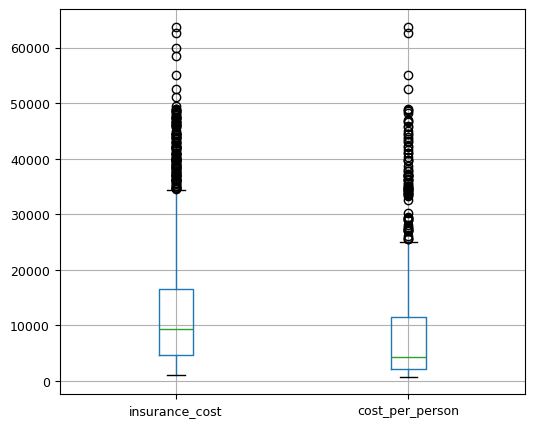

In [59]:
# Analyse the numeric features
# show these three on one plot because they have a similar scale
df.loc[:,'age':'children'].boxplot(figsize=(10,5))
plt.show()

# different scale
#df.loc[:,'insurance_cost':'insurance_cost'].boxplot(figsize=(4,5))
df.loc[:,'insurance_cost':'cost_per_person'].boxplot(figsize=(6,5))
plt.show()

In [60]:
# Prepare for the split
y = df.insurance_cost
X = df.drop(['insurance_cost','cost_per_person'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [61]:
# I want to discretise BMI into the six medical ordinals
def bmi_band(bmi):
    '''
    Underweight: Less than 18.5
    Optimum range: 18.5 to 24.9
    Overweight: 25 to 29.9
    Class I obesity: 30 to 34.9
    Class II obesity: 35 to 39.9
    '''
    if (bmi<18.5):
        band = 0
    elif (bmi<25):
        band = 1
    elif (bmi<30):
        band = 2
    elif (bmi<35):
        band = 3
    else:
        band = 4
    return band

def bmi_mapper(bmi):
    return bmi.map(lambda bmi: bmi_band(bmi) )

bmi_handler = Pipeline(steps=[
        ("hand_bmi",  FunctionTransformer(bmi_mapper, feature_names_out='one-to-one')),
        #("bmi_scale", MinMaxScaler())
        ])

age_handler = Pipeline(steps=[
    ('num_band',   KBinsDiscretizer(n_bins=16, encode='ordinal', strategy='quantile')),
    #("mm_scaler",  MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers = [
        ("numerical", MinMaxScaler(),                         ['children']),
        ("band_age",  age_handler,                            ['age']),
        ("band_bmi",  bmi_handler,                            ['bmi']),
        ("oh_smoker", OneHotEncoder(handle_unknown="ignore"), ['smoker']),
        ("oh_gender", OneHotEncoder(handle_unknown="ignore"), ['gender']),
        ("oh_region", OneHotEncoder(handle_unknown="ignore"), ['region']),
    ],
    remainder="drop"  # "passthrough" # note there are no remaining columns in this example
)

# get our preprocessed data
df2 = preprocessor.fit_transform(X_train)

col_names = preprocessor.get_feature_names_out()
# Convert to dataframe
df_prepped = pd.DataFrame(df2, columns=col_names)
# Use this to verify that all (numeric) features have a maximum value of 1
print(df_prepped.describe())

       numerical__children  band_age__age  band_bmi__bmi  oh_smoker__smoker_no  oh_smoker__smoker_yes  oh_gender__gender_female  oh_gender__gender_male  oh_region__region_northeast  oh_region__region_northwest  oh_region__region_southeast  oh_region__region_southwest
count             1,070.00       1,070.00       1,070.00              1,070.00               1,070.00                  1,070.00                1,070.00                     1,070.00                     1,070.00                     1,070.00                     1,070.00
mean                  0.22           7.65           2.55                  0.79                   0.21                      0.49                    0.51                         0.24                         0.24                         0.28                         0.24
std                   0.24           4.58           1.08                  0.41                   0.41                      0.50                    0.50                         0.43                

In [62]:
selector = Pipeline(steps=[
    ('feature_sel_1', RFE(LinearRegression())),
])

my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('feature_sel_1', selector),
    ('model', RandomForestRegressor(verbose=1, random_state=222))
])

my_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16))]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0x000001A982DE5A80>))]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  RFE(estimator=LinearRegression()))])),
                ('model', RandomForestRegressor(random_state=222, verbose=1))])

In [63]:
df3 = selector.fit_transform(df2, y_train)
print('df2 shape:',df2.shape)
print('df3 shape:',df3.shape)
print('Selector removed these features:',col_names[~selector['feature_sel_1'].get_support()])

df2 shape: (1070, 11)
df3 shape: (1070, 5)
Selector removed these features: ['oh_gender__gender_female' 'oh_gender__gender_male'
 'oh_region__region_northeast' 'oh_region__region_northwest'
 'oh_region__region_southeast' 'oh_region__region_southwest']


In [64]:
# Dimension Reduction
dimreds = [
    ('PCA1', PCA(n_components=9)),  # keep 9 of the 11
    #('PCA2', PCA(iterated_power=6)),  # too slow
    ('RFE1', RFE(estimator=LinearRegression()) ),
    ('RFE2', RFE(estimator=SVR(kernel='linear', gamma='auto')) ),
    #('LSV', SelectFromModel(LinearSVC(dual="auto", penalty="l1",max_iter=12000)) ),
    ]

In [65]:
# define our lists so that we can loop through n classifiers
best_params = {}
best_model = {}

param_grid_rfr = {
    'n_estimators' : [100,150,200], #10,20,30,40,
    'max_depth': [2, 4, 6, 8], # , 10, 15, 25
    'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
}
#fast
#param_grid_rfr = {'criterion': ['poisson'], 'max_depth': [4], 'n_estimators': [150]}

param_grid_lrg = {}

param_grid_mlp = {
    'activation' : ['tanh','relu'],
    'solver': ['adam','lbfgs'],
    'max_iter': [1000,7500,15000]
}

# fast
#param_grid_mlp = {'activation': ['relu'], 'solver': ['adam'], 'max_iter': [15000]}

rs = 21

regs = [
    ('rfr',  RandomForestRegressor(n_jobs=-1, random_state=rs), param_grid_rfr  ),
    ('lrg',  LinearRegression(n_jobs=-1),                       param_grid_lrg  ),
    ('mlp',  MLPRegressor(random_state=rs),                     param_grid_mlp  ),
]


# for each model
for reg_name, reg, param_grid in regs:
    print(reg_name, param_grid)

    # for each dimensionality reduction algorithm
    for dr_name, dr_model in dimreds:
        print('Apply Dimension Reduction using', dr_name)

        selector = Pipeline(steps=[
                ('feature_sel_1', dr_model),
                ])

        a_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor), 
            ('feature_sel_1', selector),
            ('model', reg),
        ])

        set_config(display='diagram')
        display(a_pipeline)

        search = GridSearchCV(
                    a_pipeline, 
                    {f'model__{paramname}': paramvalue for paramname, paramvalue in param_grid.items()},
                    n_jobs=-1,
                    cv=5,
                    refit=True
                    )
        
        search.fit(X_train, y_train)

        print("Best CV score = %0.3f:" % search.best_score_)
        print("Best parameters: ", search.best_params_)

        # store the best params and best model for later use
        best_params[f'{reg_name}/{dr_name}'] = search.best_params_
        best_model[f'{reg_name}/{dr_name}']  = search.best_estimator_

rfr {'n_estimators': [100, 150, 200], 'max_depth': [2, 4, 6, 8], 'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']}
Apply Dimension Reduction using PCA1


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16))]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0x000001A982DE5A80>))]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1', PCA(n_components=9))])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=21))])

Best CV score = 0.847:
Best parameters:  {'model__criterion': 'squared_error', 'model__max_depth': 4, 'model__n_estimators': 100}
Apply Dimension Reduction using RFE1


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16))]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0x000001A982DE5A80>))]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  RFE(estimator=LinearRegression()))])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=21))])

Best CV score = 0.811:
Best parameters:  {'model__criterion': 'friedman_mse', 'model__max_depth': 4, 'model__n_estimators': 100}
Apply Dimension Reduction using RFE2


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16))]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0x000001A982DE5A80>))]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  RFE(estimator=SVR(gamma='auto',
                                                    kernel='linear')))])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=21))])

Best CV score = 0.710:
Best parameters:  {'model__criterion': 'squared_error', 'model__max_depth': 4, 'model__n_estimators': 100}
lrg {}
Apply Dimension Reduction using PCA1


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16))]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0x000001A982DE5A80>))]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1', PCA(n_components=9))])),
                ('model', LinearRegression(n_jobs=-1))])

Best CV score = 0.740:
Best parameters:  {}
Apply Dimension Reduction using RFE1


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16))]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0x000001A982DE5A80>))]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  RFE(estimator=LinearRegression()))])),
                ('model', LinearRegression(n_jobs=-1))])

Best CV score = 0.708:
Best parameters:  {}
Apply Dimension Reduction using RFE2


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16))]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0x000001A982DE5A80>))]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  RFE(estimator=SVR(gamma='auto',
                                                    kernel='linear')))])),
                ('model', LinearRegression(n_jobs=-1))])

Best CV score = 0.711:
Best parameters:  {}
mlp {'activation': ['tanh', 'relu'], 'solver': ['adam', 'lbfgs'], 'max_iter': [1000, 7500, 15000]}
Apply Dimension Reduction using PCA1


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16))]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0x000001A982DE5A80>))]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1', PCA(n_components=9))])),
                ('model', MLPRegressor(random_state=21))])

Best CV score = 0.843:
Best parameters:  {'model__activation': 'relu', 'model__max_iter': 15000, 'model__solver': 'adam'}
Apply Dimension Reduction using RFE1


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16))]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0x000001A982DE5A80>))]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  RFE(estimator=LinearRegression()))])),
                ('model', MLPRegressor(random_state=21))])

Best CV score = 0.802:
Best parameters:  {'model__activation': 'relu', 'model__max_iter': 1000, 'model__solver': 'lbfgs'}
Apply Dimension Reduction using RFE2


C:\Users\peter\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['children']),
                                                 ('band_age',
                                                  Pipeline(steps=[('num_band',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=16))]),
                                                  ['age']),
                                                 ('band_bmi',
                                                  Pipeline(steps=[('hand_bmi',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bmi_mapper at 0x000001A982DE5A80>))]),
                                                  ['bmi']),
                                                 ('oh_smoker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker']),
                                                 ('oh_gender',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('oh_region',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region'])])),
                ('feature_sel_1',
                 Pipeline(steps=[('feature_sel_1',
                                  RFE(estimator=SVR(gamma='auto',
                                                    kernel='linear')))])),
                ('model', MLPRegressor(random_state=21))])

Best CV score = 0.710:
Best parameters:  {'model__activation': 'relu', 'model__max_iter': 7500, 'model__solver': 'adam'}


--- Optimal Parameters ---
rfr/PCA1 {'model__criterion': 'squared_error', 'model__max_depth': 4, 'model__n_estimators': 100}
rfr/RFE1 {'model__criterion': 'friedman_mse', 'model__max_depth': 4, 'model__n_estimators': 100}
rfr/RFE2 {'model__criterion': 'squared_error', 'model__max_depth': 4, 'model__n_estimators': 100}
lrg/PCA1 {}
lrg/RFE1 {}
lrg/RFE2 {}
mlp/PCA1 {'model__activation': 'relu', 'model__max_iter': 15000, 'model__solver': 'adam'}
mlp/RFE1 {'model__activation': 'relu', 'model__max_iter': 1000, 'model__solver': 'lbfgs'}
mlp/RFE2 {'model__activation': 'relu', 'model__max_iter': 7500, 'model__solver': 'adam'}

--- Model Performance ---
rfr/PCA1  - 0.8837   mse=15348860, mae=2319
rfr/RFE1  - 0.8841   mse=15288729, mae=2322
rfr/RFE2  - 0.7023   mse=39271248, mae=3904
lrg/PCA1  - 0.7563   mse=32159339, mae=4118
lrg/RFE1  - 0.7537   mse=32500752, mae=4149
lrg/RFE2  - 0.7272   mse=35989071, mae=3850
mlp/PCA1  - 0.8784   mse=16049047, mae=2544
mlp/RFE1  - 0.8856   mse=15092248, mae=2

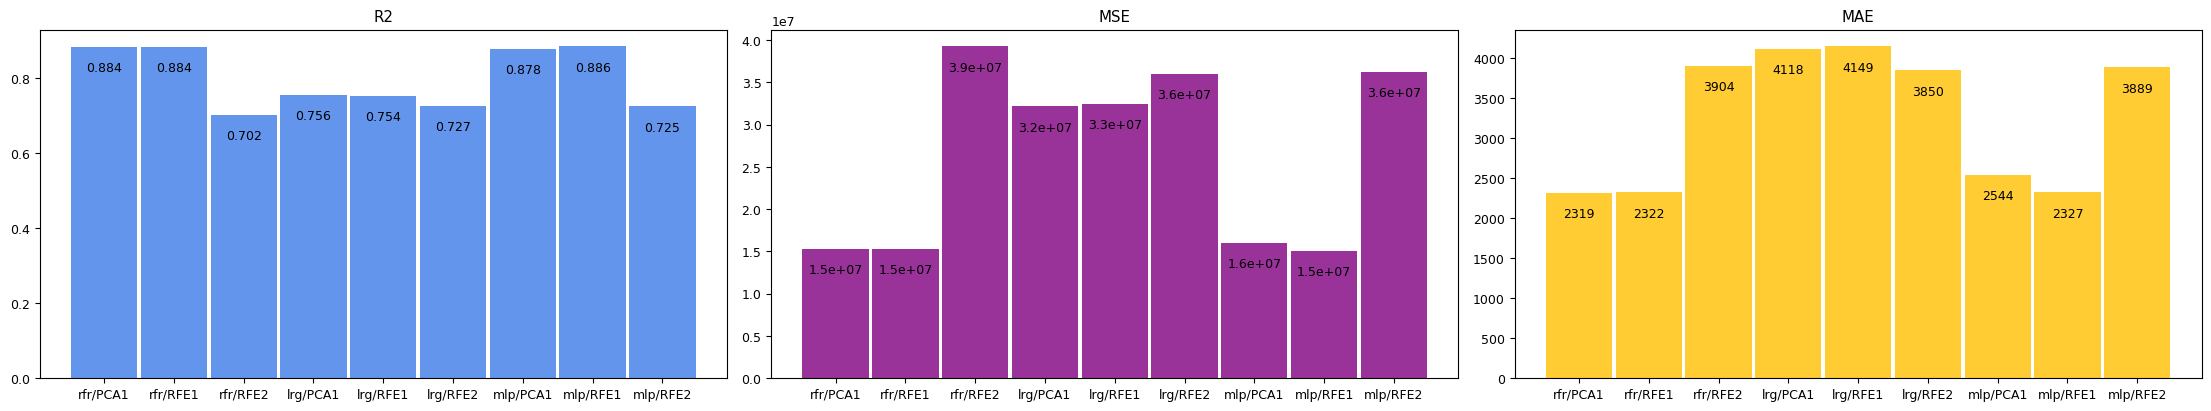

Best R2 is 0.885609991450126 for mlp/RFE1
Best MSE is 15092248.322650073 for mlp/RFE1
Best MAE is 2319.0348990452776 for rfr/PCA1


In [66]:
print('--- Optimal Parameters ---')
for x,y in best_params.items():
    print(x,y)

name_list = []
r2_list = []
mse_list = []
mae_list = []
max_r2 = 0
min_mse = np.inf
min_mae = np.inf
print('\n--- Model Performance ---')
for name, model in best_model.items():

    predictions = model.predict(X_test)
    r2  = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)

    name_list.append(name)
    r2_list.append(r2)
    mse_list.append(mse)
    mae_list.append(mae)

    if (r2 > max_r2):
        max_r2 = r2
        best_r2 = name

    if (mse < min_mse):
        min_mse = mse
        best_mse = name

    if (mae < min_mae):
        min_mae = mae
        best_mae = name
        
    print(f'{name}  - {r2:.4f}   {mse=:.0f}, {mae=:.0f}')

fig, (ax_r2,ax_mse, ax_mae) = plt.subplots(1,3,figsize=(22,4),layout='constrained')
plt.rcParams['font.size'] = 9

bars = ax_r2.bar(name_list, r2_list,color='cornflowerblue', width=0.95)
ax_r2.bar_label(bars, fmt='{:.3f}', padding=-20)
ax_r2.set_title('R2')

bars = ax_mse.bar(name_list, mse_list,color='#939', width=0.95)
ax_mse.bar_label(bars, fmt='{:.1e}', padding=-20)
ax_mse.set_title('MSE')

bars = ax_mae.bar(name_list, mae_list,color='#fc3', width=0.95)
ax_mae.bar_label(bars, fmt='{:3.0f}', padding=-20)
ax_mae.set_title('MAE')
plt.show()

print(f'Best R2 is {max_r2} for {best_r2}')
print(f'Best MSE is {min_mse} for {best_mse}')
print(f'Best MAE is {min_mae} for {best_mae}')

# Conclusion
I used similar data preparation pipelines to the ones I used for the Classification task.  

The most accurate results are from the use of the MLP regressor with RFE dimensional reduction and the LRG regressor performed poorly.

I found it interesting that the Dimension Reduction algorithm that I analysed (RFE) dropped different features to those dropped in my Classification analysis of Task 1, namely BMI, gender and three of the four regions (retaining northeast).  This implies that the classification approach of using the median of the insurance_cost may not be the best approach. I am not 100% confident that I am correctly identifying or interpreting those features - can you please clarify Moderator?